In [110]:
#pip install keras-tuner

In [111]:
import pandas as pd
from fredapi import Fred
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout,TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import itertools
import io
import platform
import asyncio
import pickle
import warnings
warnings.filterwarnings("ignore")


In [112]:
## Initialize the Fredapi key with your apikey

api_key="1b5e76d94e9dc29c08bc917cd9074004 "
fred=Fred(api_key=api_key)


In [113]:
## Fetch Libya GDP data

libya=fred.get_series("LBYNGDPDUSD")
libya.head()


2000-01-01    3.949755e+10
2001-01-01    3.520561e+10
2002-01-01    2.112762e+10
2003-01-01    2.702589e+10
2004-01-01    3.405394e+10
dtype: float64

In [114]:
## convert to a dataframe and rename the column
libya_df=libya.to_frame(name="GDP_USD")
libya_df.head()


,GDP_USD
2000-01-01,3.949755e+10
2001-01-01,3.520561e+10
2002-01-01,2.112762e+10
2003-01-01,2.702589e+10
2004-01-01,3.405394e+10


In [115]:
libya_df = libya_df.reset_index()
libya_df.rename(columns={'index': 'ds'}, inplace=True)
libya_df["ds"] = pd.to_datetime(libya_df["ds"])


In [116]:
libya_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       26 non-null     datetime64[ns]
 1   GDP_USD  26 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 548.0 bytes


In [117]:
## make date the index 

libya_df.set_index('ds', inplace=True)
#libya_df.index

In [118]:
libya_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 2000-01-01 to 2025-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GDP_USD  26 non-null     float64
dtypes: float64(1)
memory usage: 416.0 bytes


In [119]:
libya_df.isnull().sum()

GDP_USD    0
dtype: int64

In [120]:
#Resample data to quartely frequency
libya_df_quarterly=libya_df.resample('QE').mean().interpolate(method='linear')
# display the resampled data
print(libya_df_quarterly.head(12))

                 GDP_USD
ds                      
2000-03-31  3.949755e+10
2000-06-30  3.842457e+10
2000-09-30  3.735158e+10
2000-12-31  3.627860e+10
2001-03-31  3.520561e+10
2001-06-30  3.168612e+10
2001-09-30  2.816662e+10
2001-12-31  2.464712e+10
2002-03-31  2.112762e+10
2002-06-30  2.260219e+10
2002-09-30  2.407675e+10
2002-12-31  2.555132e+10


In [121]:
#  Ensure numeric values

libya_df_quarterly['GDP_USD']=pd.to_numeric(libya_df_quarterly['GDP_USD'],errors='coerce')

if libya_df_quarterly['GDP_USD'].isna().sum()>0:
    raise ValueError("non_numeric valuesfound in the GDP data")

In [122]:
#check for missing values

libya_df_quarterly.isnull().sum()

GDP_USD    0
dtype: int64

In [123]:
## Feature engineering
# create lag feaatures for 4quarrters
libya_df_quarterly['lag_1']=libya_df_quarterly['GDP_USD'].shift(4)



In [124]:
#Create rolling mean and (window = 4 quarters) 1 year rolling mean
libya_df_quarterly['rolling_mean_4'] = libya_df_quarterly['GDP_USD'].rolling(window=4).mean()


In [125]:
# Show first 10 rows of the updated DataFrame
print(libya_df_quarterly.head(10))

                 GDP_USD         lag_1  rolling_mean_4
ds                                                    
2000-03-31  3.949755e+10           NaN             NaN
2000-06-30  3.842457e+10           NaN             NaN
2000-09-30  3.735158e+10           NaN             NaN
2000-12-31  3.627860e+10           NaN    3.788807e+10
2001-03-31  3.520561e+10  3.949755e+10    3.681509e+10
2001-06-30  3.168612e+10  3.842457e+10    3.513048e+10
2001-09-30  2.816662e+10  3.735158e+10    3.283424e+10
2001-12-31  2.464712e+10  3.627860e+10    2.992637e+10
2002-03-31  2.112762e+10  3.520561e+10    2.640687e+10
2002-06-30  2.260219e+10  3.168612e+10    2.413589e+10


In [126]:
print(libya_df_quarterly.columns)

Index(['GDP_USD', 'lag_1', 'rolling_mean_4'], dtype='object')


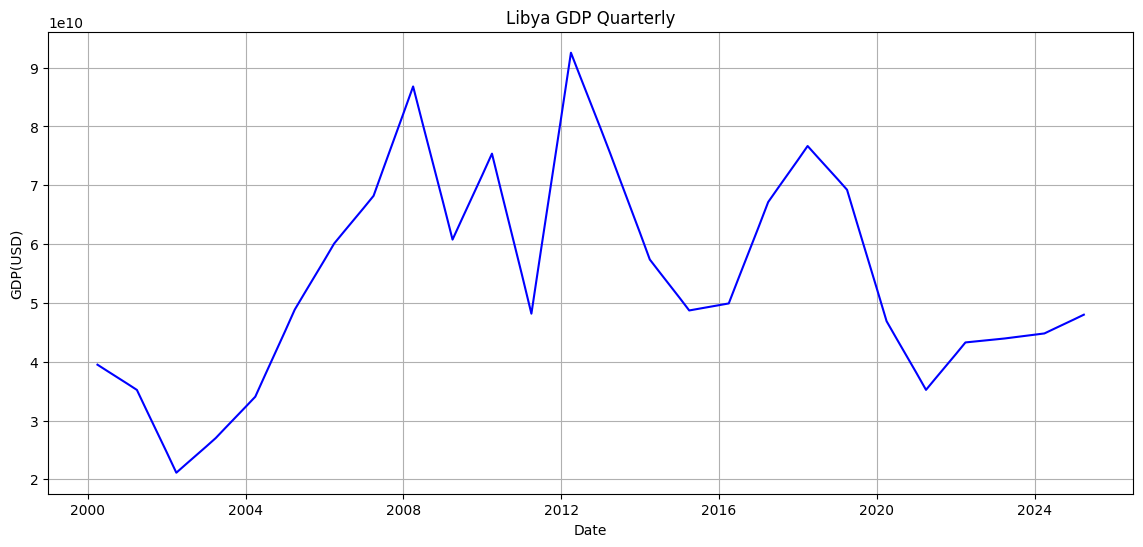

In [127]:
# EXPLOLATORY DATA ANALYSIS(quarterly data)

#Visualize Trends - Visualizes the overall trend of your time series.
plt.figure(figsize=(14,6))
#sns.lineplot(data=libya_df_quarterly, x=libya_df_quarterly.index, y=libya_df_quarterly.columns[0])
plt.plot(libya_df_quarterly.index, libya_df_quarterly['GDP_USD'],'b-', label=['Quartely GDP'])
plt.title('Libya GDP Quarterly')
plt.xlabel('Date')
plt.ylabel('GDP(USD)')
plt.grid(True)
plt.show()


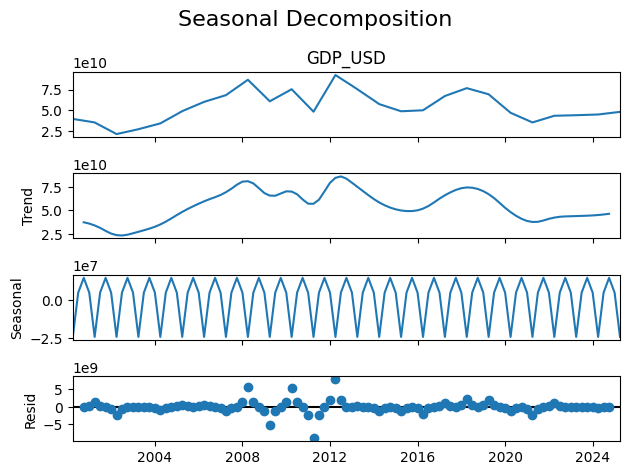

In [128]:
#Seasonal Decomposition - breaks the series into trend, seasonal, and residual components
result = seasonal_decompose(libya_df_quarterly['GDP_USD'], model='additive', period=4)  # quarterly data period=4
result.plot()
plt.suptitle('Seasonal Decomposition', size=16)
plt.tight_layout()
plt.show()

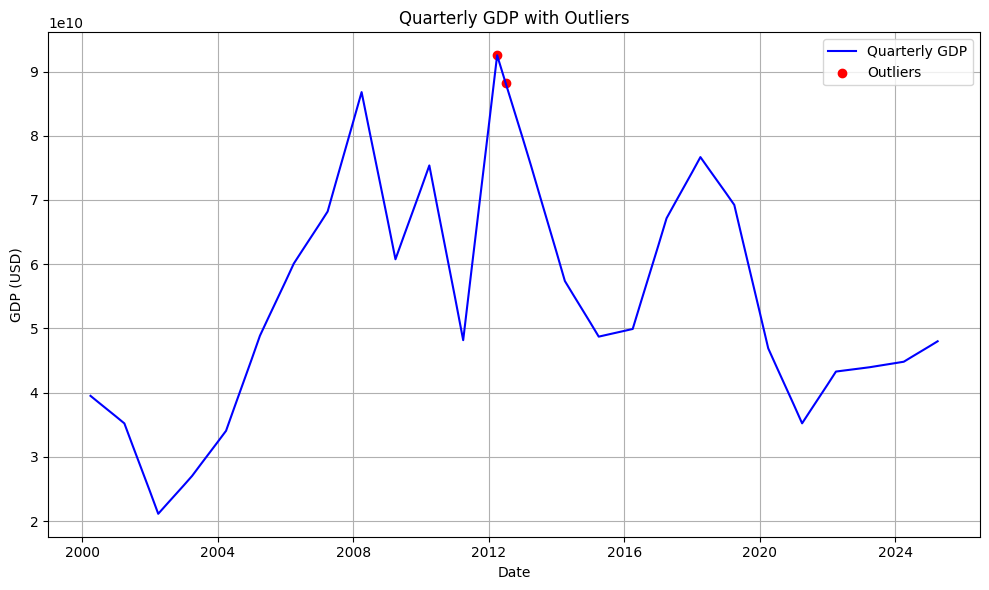

In [129]:
## Detect outlers using z-scores
libya_df_quarterly['z_score']=(libya_df_quarterly['GDP_USD']-libya_df_quarterly['GDP_USD'].mean())/libya_df_quarterly['GDP_USD'].std()
outliers=libya_df_quarterly[np.abs(libya_df_quarterly['z_score'])>2]
plt.figure(figsize=(10,6))
plt.plot(libya_df_quarterly.index, libya_df_quarterly['GDP_USD'],'b-',label='Quarterly GDP')
plt.scatter(outliers.index, outliers['GDP_USD'], color='red', label='Outliers')
plt.title('Quarterly GDP with Outliers')
plt.xlabel('Date')
plt.ylabel('GDP (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [130]:
#Stationary test(ADF)
adf_result=adfuller(libya_df_quarterly['GDP_USD'])
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
print("The data is likely", "stationary." if adf_result[1] < 0.05 else "non-stationary.")


ADF Statistic: -2.9588, p-value: 0.0389
The data is likely stationary.


In [131]:
libya_df_quarterly=libya_df_quarterly.reset_index()
libya_df_quarterly=libya_df_quarterly.rename(columns={'Year':'ds', 'GDP_USD':'y'})

# ds in datetime format
libya_df_quarterly['ds']=pd.to_datetime(libya_df_quarterly['ds'])

12:09:02 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing


Test MAE: 6122705812.26, Test RMSE: 7776082529.19, Test MAPE: 15.13%


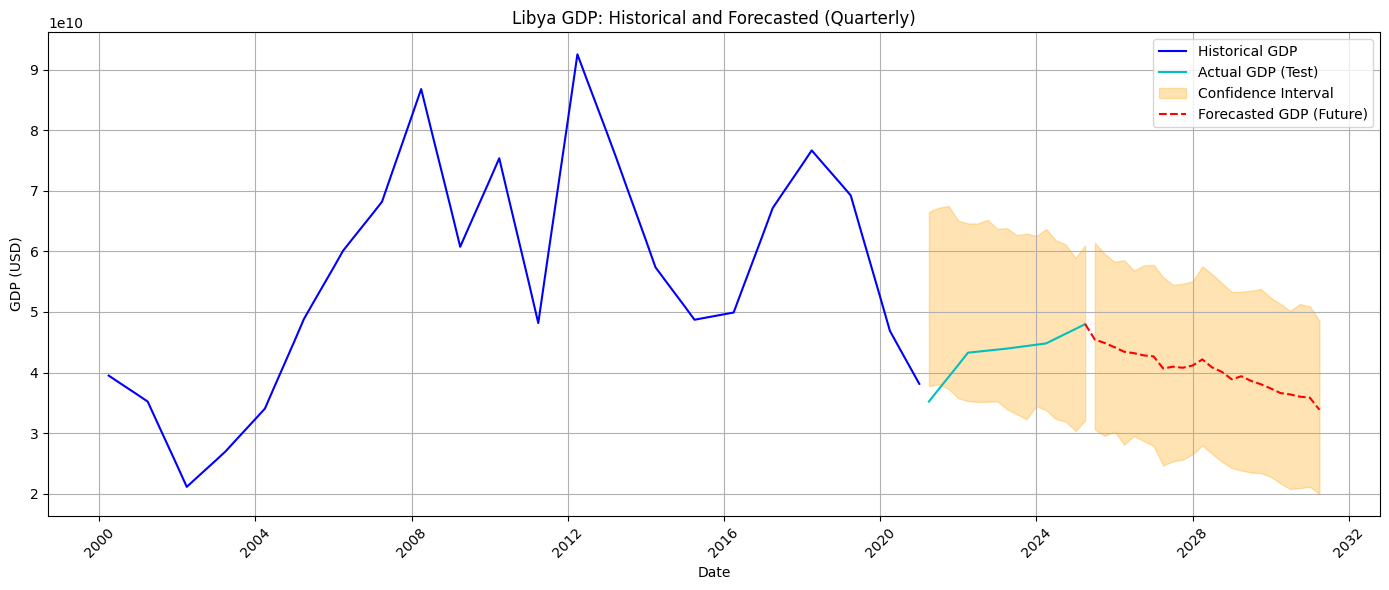

In [132]:
# 3. Modeling and Forecasting
"""Fit Prophet model, evaluate, forecast, and visualize for quarterly data."""
# Split data: train (2000-2020), test (2021-2025)
train = libya_df_quarterly[libya_df_quarterly['ds'] <= '2025-03-31']
test = libya_df_quarterly[(libya_df_quarterly['ds'] > '2020-12-31') & (libya_df_quarterly['ds'] <= '2025-03-31')]
    
# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(train)
    
# Evaluate on test set
future_test = pd.DataFrame({'ds': test['ds']})
forecast_test = model.predict(future_test)


# Evluate Performance
mae = mean_absolute_error(test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test['y'], forecast_test['yhat']))
#non_zero_mask = test['y'] != 0
#mape = np.mean(np.abs((test['y'] - forecast_test['yhat']) / test['y'])) * 100
def safe_mape(y_true, y_pred):
    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = safe_mape(test['y'], forecast_test['yhat'])

print(f"Test MAE: {mae:.2f}, Test RMSE: {rmse:.2f}, Test MAPE: {mape:.2f}%")


# Forecast future (2026Q1-2031Q4, 24 quarters to align with image ~2031)
future = model.make_future_dataframe(periods=24, freq='Q', include_history=True)
forecast = model.predict(future)
    
# --- Plotting historical, test, and forecast ---
plt.figure(figsize=(14, 6))

# Historical
historical_df = libya_df_quarterly[libya_df_quarterly['ds'] <= '2020-12-31']
plt.plot(historical_df['ds'], historical_df['y'], 'b-', label='Historical GDP', )

# Test
plt.plot(test['ds'], test['y'], 'c-', label='Actual GDP (Test)')
forecast_test_match = forecast[forecast['ds'].isin(test['ds'])]
#plt.plot(forecast_test_match['ds'], forecast_test_match['yhat'], 'r--', label='Forecasted GDP (Test)', marker='o')

# Confidence interval for test
plt.fill_between(forecast_test_match['ds'], 
                 forecast_test_match['yhat_lower'], 
                 forecast_test_match['yhat_upper'], 
                 color='orange', alpha=0.3, label='Confidence Interval')



# Forecast beyond 2025
forecast_future = forecast[forecast['ds'] > '2025-03-31']

# Append last actual point to the forecast to make line continuous
last_actual_point = test.iloc[-1][['ds', 'y']]
continuous_forecast = pd.concat([
    pd.DataFrame({'ds': [last_actual_point['ds']], 'yhat': [last_actual_point['y']]}),
    forecast_future[['ds', 'yhat']]
])
#plt.plot(forecast_future['ds'], forecast_future['yhat'], 'r--', label='Forecasted GDP (Future)', marker='o')
plt.plot(continuous_forecast['ds'], continuous_forecast['yhat'], 'r--', label='Forecasted GDP (Future)',)

plt.fill_between(forecast_future['ds'], 
                 forecast_future['yhat_lower'], 
                 forecast_future['yhat_upper'], 
                 color='orange', alpha=0.3)

# Final plot settings
plt.title("Libya GDP: Historical and Forecasted (Quarterly)")
plt.xlabel("Date")
plt.ylabel("GDP (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [133]:
# SARIMA model
# set datetime index

gdp_series=libya_df_quarterly.set_index('ds')['y']
gdp_series=gdp_series.asfreq('Q')


In [134]:

# SARIMA(p,d,q)(P,D,Q,s), try (1,1,1)(1,1,0,4)
model = SARIMAX(gdp_series[:'2025-03-31'], 
                order=(1,1,1), 
                seasonal_order=(1,1,0,4), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  101
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 4)   Log Likelihood               -2139.432
Date:                            Mon, 02 Jun 2025   AIC                           4286.865
Time:                                    12:09:03   BIC                           4296.908
Sample:                                03-31-2000   HQIC                          4290.916
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7244      0.248      2.922      0.003       0.239       1.210
ma.L1          0.0894      0.697   

In [135]:
# Forecast 24 quarters (6 years)
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start='2025-06-30', periods=forecast_steps, freq='Q')

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_ci.index = forecast_index
forecast_mean.index = forecast_index


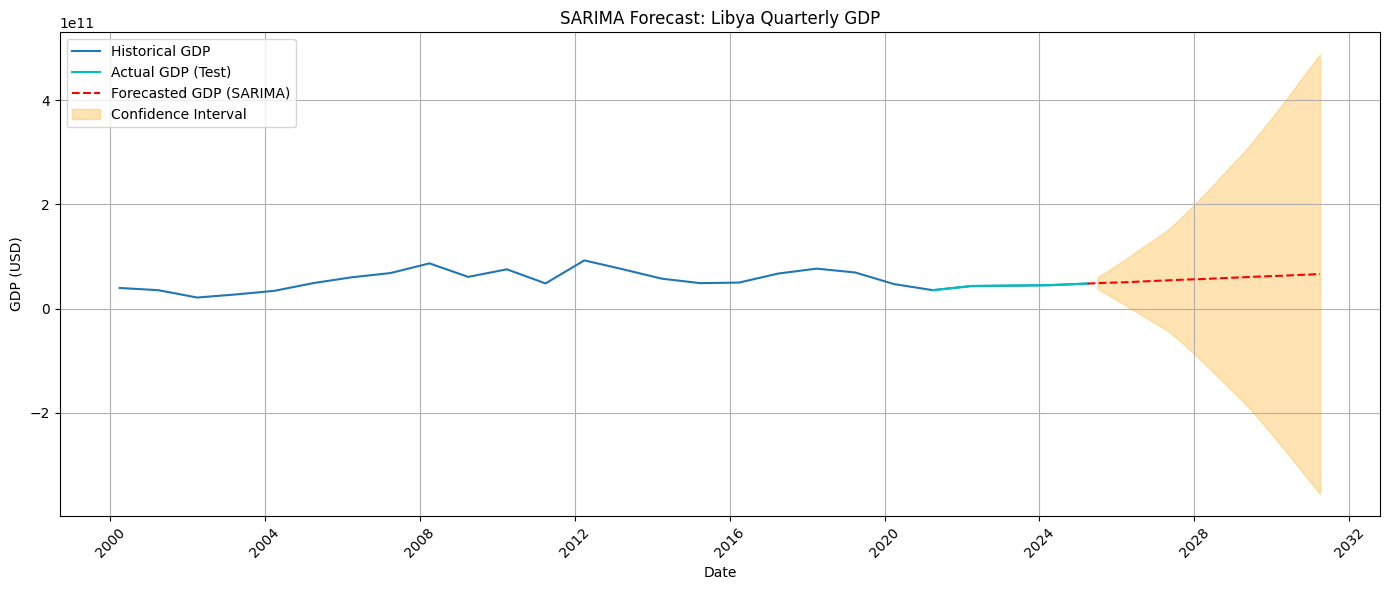

In [136]:

# Last actual test data point
last_actual = gdp_series.loc['2025-03-31']

# Combine last actual point with forecast to create continuous forecast line
combined_forecast_values = np.concatenate([[last_actual], forecast_mean.values])
combined_forecast_index = pd.date_range(start='2025-03-31', periods=forecast_steps + 1, freq='Q')
combined_forecast_series = pd.Series(combined_forecast_values, index=combined_forecast_index)

plt.figure(figsize=(14, 6))

# Plot full historical data (train + test)
plt.plot(gdp_series, label='Historical GDP')

# Highlight actual test period in cyan
plt.plot(gdp_series['2021':], label='Actual GDP (Test)', color='c')

# Plot continuous forecast line starting at last actual point (red dashed)
plt.plot(combined_forecast_series, label='Forecasted GDP (SARIMA)', linestyle='--', color='r')

# Plot confidence interval for forecast (starting from forecast index, not including last actual)
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='orange', alpha=0.3, label='Confidence Interval')

plt.title("SARIMA Forecast: Libya Quarterly GDP")
plt.xlabel("Date")
plt.ylabel("GDP (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [137]:
# Set GDP series with datetime index
gdp_series = libya_df_quarterly.set_index('ds')['y']
gdp_series = gdp_series.asfreq('Q')

# Define parameter ranges
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 4  # Quarterly data

# Generate all combinations of p, d, q and seasonal P, D, Q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

# Track best results
best_aic = float("inf")
best_params = None
best_model = None

# Grid search
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(gdp_series[:'2025-03-31'],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
                best_model = results
        except:
            continue

# Print best model
print("Best SARIMA parameters:")
print(f"Order: {best_params[0]}, Seasonal Order: {best_params[1]}")
print(f"Best AIC: {best_aic:.2f}")


Best SARIMA parameters:
Order: (0, 2, 2), Seasonal Order: (1, 1, 1, 4)
Best AIC: 4166.33


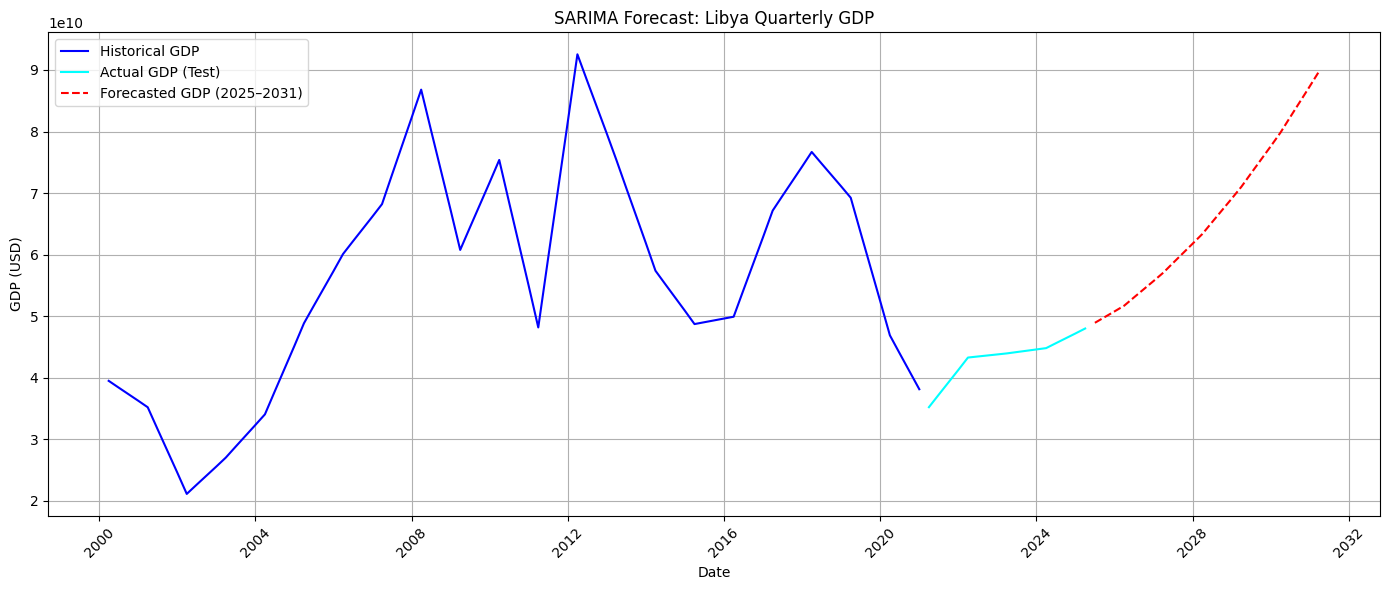

In [138]:
# Forecast future 24 quarters

pred_test = best_model.get_prediction(start='2021-03-31', end='2025-03-31')
pred_mean_test = pred_test.predicted_mean
actual_test = gdp_series['2021-03-31':'2025-03-31']

#historical_series = gdp_series[:'2025-03-31']
forecast_steps = 24
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start='2025-06-30', periods=forecast_steps, freq='Q')

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

# Combine historical + test + forecast
train_series = gdp_series[:'2020-12-31']
test_series = gdp_series['2021-03-31':'2025-03-31']


# Create continuous forecast line
last_actual = gdp_series.loc['2025-03-31']
combined_forecast = pd.Series(
    np.concatenate([[last_actual], forecast_mean.values]),
    index=pd.date_range(start='2025-03-31', periods=forecast_steps + 1, freq='Q')
)

full_series = pd.concat([gdp_series, forecast_mean])

# Plot

plt.figure(figsize=(14, 6))
plt.plot(train_series, label="Historical GDP", color="blue")
plt.plot(test_series, label="Actual GDP (Test)", color="cyan")
plt.plot(forecast_mean, label="Forecasted GDP (2025–2031)", linestyle="--", color="red")

plt.title("SARIMA Forecast: Libya Quarterly GDP")
plt.xlabel("Date")
plt.ylabel("GDP (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [139]:


mae = mean_absolute_error(actual_test, pred_mean_test)
rmse = np.sqrt(mean_squared_error(actual_test, pred_mean_test))
mape = np.mean(np.abs((actual_test - pred_mean_test) / actual_test)) * 100

print(f"SARIMA Test MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


SARIMA Test MAE: 841978124.78, RMSE: 2176180420.48, MAPE: 2.14%


In [140]:
# Combine forecast into a DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_mean.index,
    'Forecasted_GDP': forecast_mean.values,
    'Lower_CI': forecast_ci.iloc[:, 0].values,
    'Upper_CI': forecast_ci.iloc[:, 1].values
})

# Save to CSV
forecast_df.to_csv("sarima_gdp_forecast.csv", index=False)
print("SARIMA forecast saved to sarima_gdp_forecast.csv")


SARIMA forecast saved to sarima_gdp_forecast.csv


In [141]:

with open("sarima_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


In [142]:
# LSTM

# Set time series with datetime index
gdp_series = libya_df_quarterly.set_index('ds')['y']
gdp_series = gdp_series.asfreq('Q')

# Scale data
scaler = MinMaxScaler()
scaled_gdp = scaler.fit_transform(gdp_series.values.reshape(-1, 1))


In [143]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 8  # 2 years worth of quarterly data
X, y = create_sequences(scaled_gdp, window_size)

# Split into train/test (e.g., train: up to 2020Q4)
split_idx = gdp_series.index.get_loc('2021-03-31') - window_size
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [144]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=100, verbose=0)


In [145]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)

# Future forecasting: recursive prediction
forecast_steps = 24
last_window = scaled_gdp[-window_size:]
future_preds = []

for _ in range(forecast_steps):
    input_seq = last_window.reshape((1, window_size, 1))
    pred = model.predict(input_seq, verbose=0)[0]
    future_preds.append(pred[0])
    last_window = np.append(last_window[1:], pred)  # slide window

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


In [146]:
# Create future dates 
forecast_steps = len(future_preds_inv)
future_dates = pd.date_range(start=pd.to_datetime("2025-03-31") + pd.offsets.QuarterEnd(), periods=forecast_steps, freq='Q')


# Combine historical + test + future forecast
actual_series = gdp_series[:'2025-03-31']
forecast_series = pd.Series(future_preds_inv.flatten(), index=future_dates)

# Combine into one continuous series
full_series = pd.concat([actual_series, forecast_series])


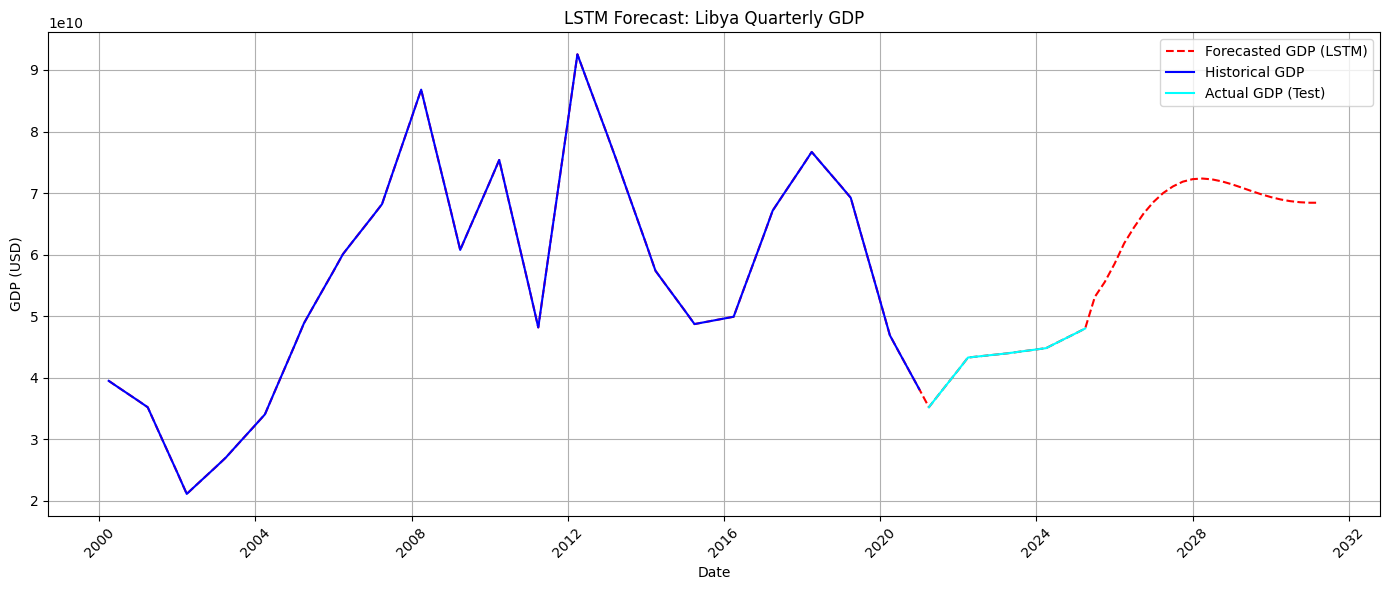

In [147]:
plt.figure(figsize=(14, 6))

# Plot continuous actual + forecasted line (same colors as original parts)
plt.plot(full_series.index, full_series.values, label='Forecasted GDP (LSTM)', linestyle='--', color='red')

# Optionally: add dots for historical and test for visual emphasis (optional)
plt.plot(gdp_series[:'2020-12-31'], label='Historical GDP', color='blue')
plt.plot(gdp_series['2021-03-31':'2025-03-31'], label='Actual GDP (Test)', color='cyan')

plt.title("LSTM Forecast: Libya Quarterly GDP")
plt.xlabel("Date")
plt.ylabel("GDP (USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [148]:
def safe_mape(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
print(f"LSTM Test RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")


LSTM Test RMSE: 4642431285.61, MAE: 4171534339.85, MAPE: 2.14%


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.3080 - val_loss: 0.0408
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1006 - val_loss: 0.2813
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0742 - val_loss: 0.0793
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0640 - val_loss: 0.0502
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0580 - val_loss: 0.1114
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0499 - val_loss: 0.1369
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0440 - val_loss: 0.0681
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0434 - val_loss: 0.0743
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0355 - val_loss: 0.1179
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0435 - val_loss: 0.0690
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0405 - val_loss: 0.0743


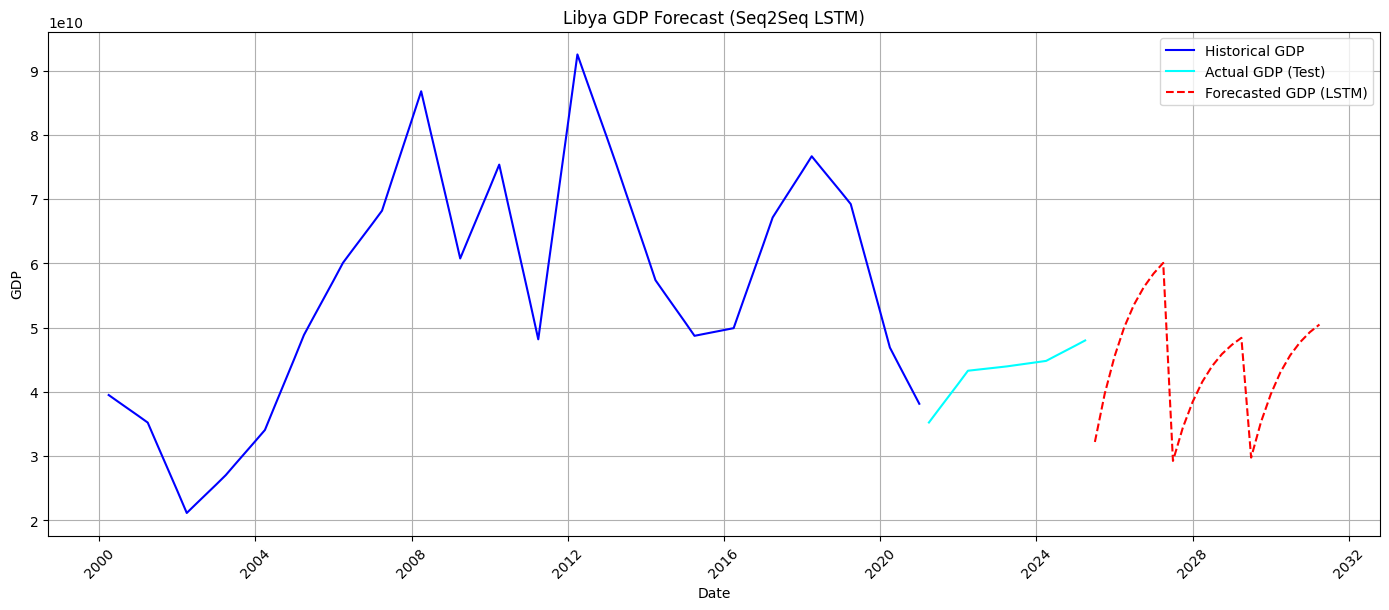

In [153]:
libya_df_quarterly['quarter'] = libya_df_quarterly['ds'].dt.quarter
libya_df_quarterly['year'] = libya_df_quarterly['ds'].dt.year
libya_df_quarterly.rename(columns={'y': 'GDP'}, inplace=True)

# === Feature and target selection ===
features = ['GDP', 'quarter', 'year']
target = 'GDP'
X_raw = libya_df_quarterly[features].values
y_raw = libya_df_quarterly[[target]].values

# === Scaling ===
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# === Sequence creation ===
def create_sequences(X, y, lookback=8, horizon=8):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback - horizon + 1):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback:i+lookback+horizon])
    return np.array(X_seq), np.array(y_seq)

lookback = 8
forecast_horizon = 8
X, y = create_sequences(X_scaled, y_scaled, lookback, forecast_horizon)

# === Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Model definition ===
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(lookback, X.shape[2])))
model.add(Dropout(0.2))
model.add(RepeatVector(forecast_horizon))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(32, activation='relu')))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

# === Recursive forecast for 24 quarters ===
future_preds_scaled = []
last_input = X_test[-1].copy()
current_year = libya_df_quarterly['year'].iloc[-1]
start_quarter = libya_df_quarterly['quarter'].iloc[-1] + 1

for _ in range(3):  # 3 * 8 = 24
    input_seq = last_input.reshape(1, lookback, X.shape[2])
    pred = model.predict(input_seq, verbose=0)[0].reshape(-1, 1)
    future_preds_scaled.extend(pred)
    
    quarters = [(start_quarter + i - 1) % 4 + 1 for i in range(forecast_horizon)]
    years = [current_year + ((start_quarter + i - 1) // 4) for i in range(forecast_horizon)]
    start_quarter += forecast_horizon
    current_year = years[-1]
    
    new_time_features = np.array(list(zip(quarters, years)))
    new_input_raw = np.hstack([pred, new_time_features])
    new_input_scaled = scaler_x.transform(new_input_raw)
    last_input = np.vstack([last_input[forecast_horizon:], new_input_scaled])

# === Create forecast series ===
future_preds_inv = scaler_y.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))
forecast_dates = pd.date_range(start=libya_df_quarterly['ds'].iloc[-1] + pd.offsets.QuarterEnd(), periods=24, freq='Q')
forecast_series = pd.Series(future_preds_inv.flatten(), index=forecast_dates)

# === Combine and plot ===
actual_gdp_series = libya_df_quarterly.set_index('ds')['GDP']
plt.figure(figsize=(14, 6))
plt.plot(actual_gdp_series[:'2020-12-31'], label='Historical GDP', color='blue')
plt.plot(actual_gdp_series['2021-03-31':'2025-03-31'], label='Actual GDP (Test)', color='cyan')
plt.plot(forecast_series.index, forecast_series.values, label='Forecasted GDP (LSTM)', linestyle='--', color='red')
plt.title("Libya GDP Forecast (Seq2Seq LSTM)")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
